In [75]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision import transforms 
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision.transforms import ToTensor, Normalize, Compose
from PIL import Image
import math
from torch.utils.data import DataLoader
import numpy as np
from torch.optim import AdamW
from diffusers import UNet2DModel
from diffusers import DDPMScheduler, DDPMPipeline
from accelerate import Accelerator

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

## Plot Our Image

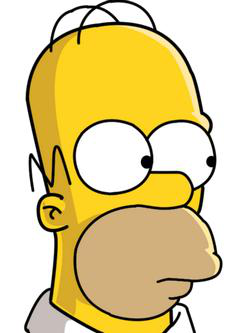

In [77]:
img = Image.open('homer.jpeg')
img

## Preprocess

In [78]:
transform = Compose([
    transforms.Resize((128, 128)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust as needed
])

# Apply transformations
image_tensor = transform(img).unsqueeze(0)  # Add batch dimension
image_tensor = image_tensor.to("cuda" if torch.cuda.is_available() else "cpu")
print(image_tensor.shape)

torch.Size([1, 3, 128, 128])


## Load Pre-trained model

In [79]:
model = UNet2DModel(
    sample_size=128,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

## Noise Scheduler

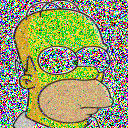

In [80]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(image_tensor.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(image_tensor, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

## Training Loop

In [81]:
"""
def image_reconstruction(image_tensor, noisy_img, model_output, epoch):
    with torch.no_grad():  # No gradients are needed for visualization

        reconstructed_img = noisy_img - model_output
        reconstructed_img = reconstructed_img.squeeze(0)  # Remove batch dimension
        reconstructed_img = reconstructed_img.permute(1, 2, 0)  # Convert to HWC format
        reconstructed_img = (reconstructed_img + 1) / 2
        # Clamp values to a valid range BEFORE converting to numpy
        reconstructed_img = reconstructed_img.clamp(0, 1)
        
        # Now it is safe to convert to numpy
        reconstructed_img_np = reconstructed_img.squeeze().cpu().numpy()
        
        return reconstructed_img_np
    """
    
def visualize(image_tensor, noisy_image, predicted_noise, epoch):
    #reconstructed_img = image_reconstruction(image_tensor, noisy_image, predicted_noise, epoch)
    img = image_tensor.squeeze().cpu().detach().numpy()
    noisy_img = noisy_image.squeeze().cpu().detach().numpy()
    pred_noise = predicted_noise.squeeze().cpu().detach().numpy()
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img.transpose(1, 2, 0))
    axs[0].set_title('Original Image')
    axs[1].imshow(noisy_img.transpose(1, 2, 0))
    axs[1].set_title('Noisy Image')
    axs[2].imshow(pred_noise.transpose(1, 2, 0))
    axs[2].set_title('Predicted Noise')
    #axs[3].imshow(reconstructed_img)
    #axs[3].set_title('Reconstructed Image')

    for ax in axs:
        ax.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

/Users/alexisrevelle/miniconda3/envs/data-science/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/4000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0: Loss = 1.1457


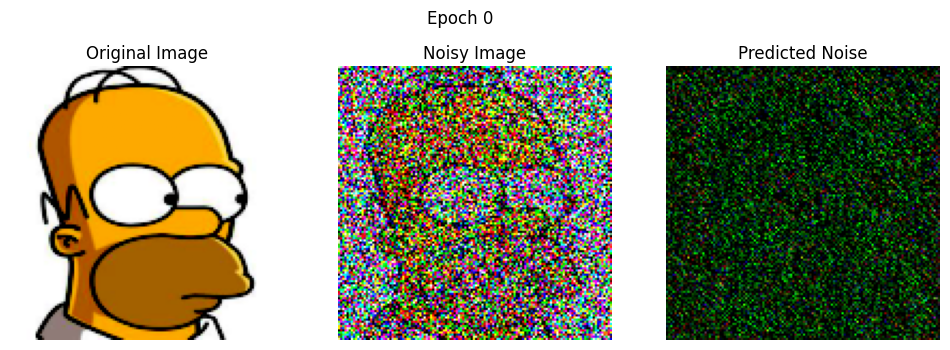

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 400: Loss = 0.0191


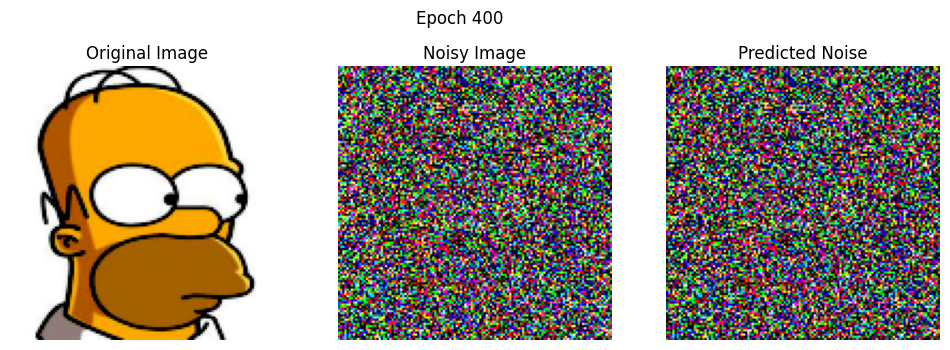

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 800: Loss = 0.0106


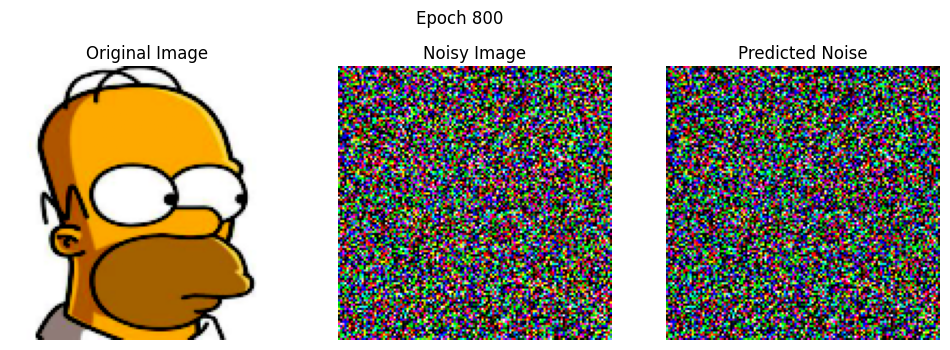

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1200: Loss = 0.0074


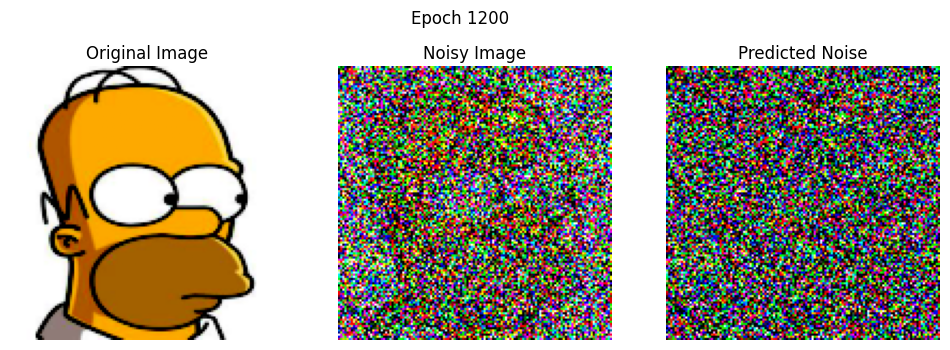

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1600: Loss = 0.0080


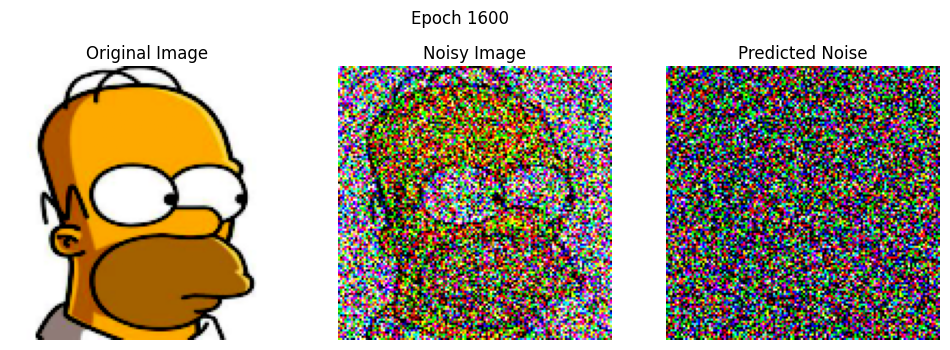

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2000: Loss = 0.6734


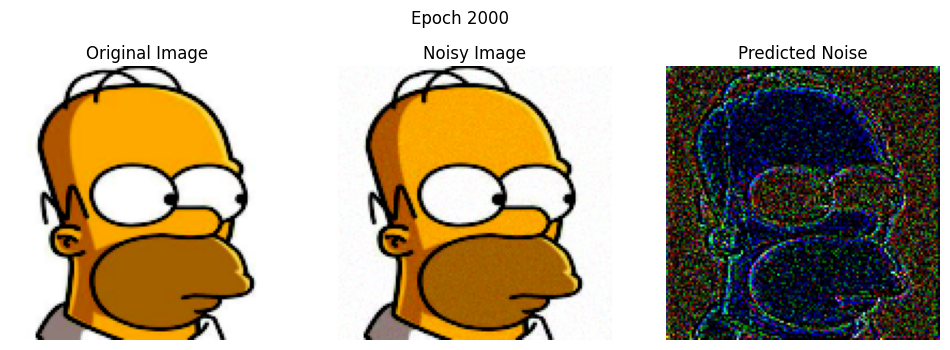

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2400: Loss = 0.0018


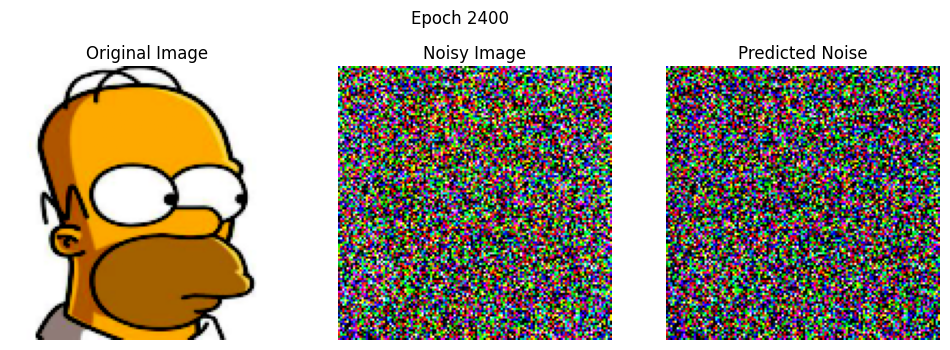

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2800: Loss = 0.0014


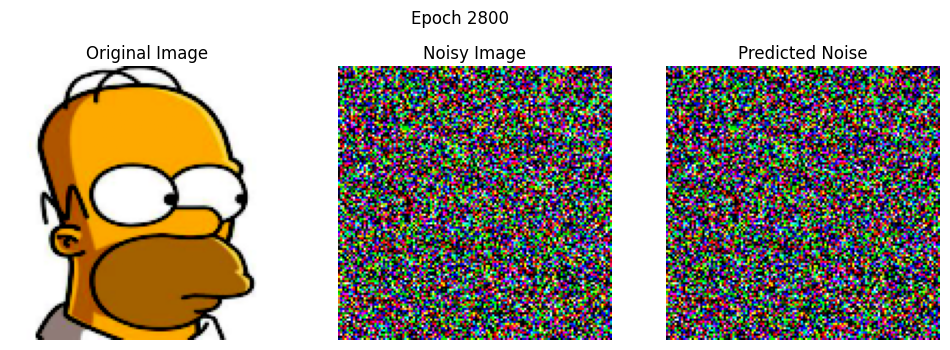

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3200: Loss = 0.0013


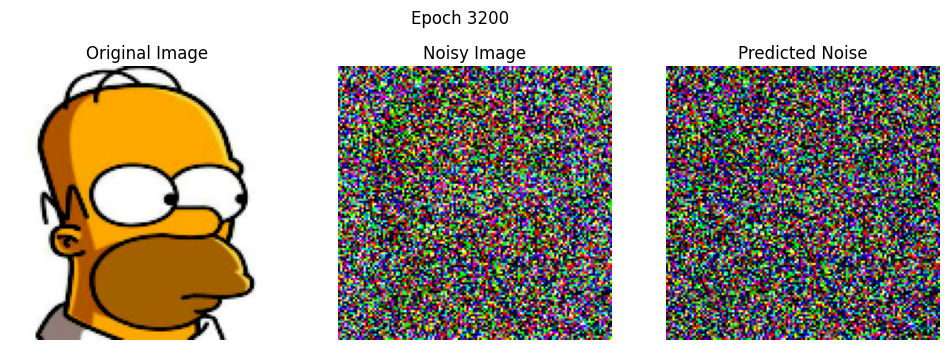

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3600: Loss = 0.0082


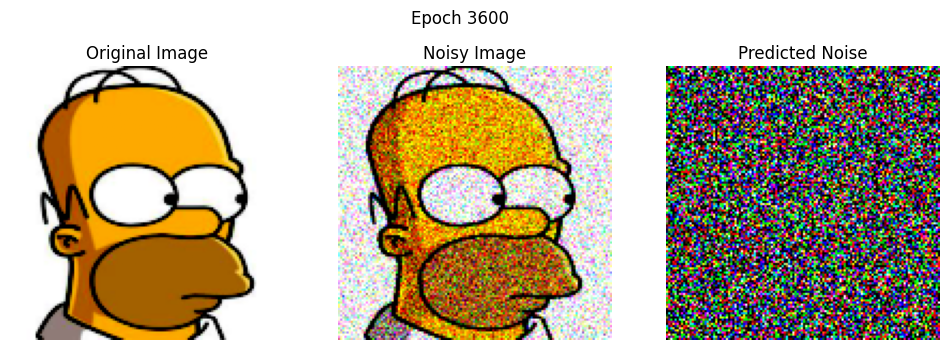

Training Time: 2439.25s


In [82]:
from transformers import AdamW, get_cosine_schedule_with_warmup
from accelerate import Accelerator
import torch
import torch.nn.functional as F
import timeit
from tqdm.auto import tqdm

# Constants (adjust these as necessary)
NUM_EPOCHS = 10000
LEARNING_RATE = 5e-5
NUM_WARMUP_STEPS = 500
MIXED_PRECISION = "no"  # Or "fp16"
GRADIENT_ACCUMULATION_STEPS = 1
NUM_GENERATE_IMAGES = 1  # Number of images you want to generate
RANDOM_SEED = 42
NUM_TIMESTEPS = 50

# Model setup (assuming `model` is already defined and configured)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=NUM_EPOCHS  # Since we're doing 1 step per epoch
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, lr_scheduler = accelerator.prepare(model, optimizer, lr_scheduler)

# Assume `image_tensor` and `device` are already defined
image_tensor = image_tensor.to(accelerator.device)  # Adjust to use Accelerator's device handling
noise_scheduler = noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

loss_values = []
noisy_images = []
noise_preds = []

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    
    noise = torch.randn(image_tensor.shape).to(accelerator.device)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (1,)).to(accelerator.device)
    noisy_image = noise_scheduler.add_noise(image_tensor, noise, timesteps)
    noisy_images.append(noisy_image)

    with accelerator.accumulate(model):
        noise_pred = model(noisy_image, timesteps, return_dict=False)[0]
        noise_preds.append(noise_pred)
        loss = F.mse_loss(noise_pred, noise)
        loss_values.append(loss)
        accelerator.backward(loss)
        
        accelerator.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step() 
        optimizer.zero_grad()
    
    
    if (epoch) % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
        visualize(image_tensor, noisy_image, noise_pred, epoch)
        

stop = timeit.default_timer()
print(f"Training Time: {stop - start:.2f}s")

In [67]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    return images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

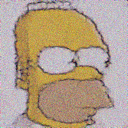

In [68]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, 1000)

  0%|          | 0/500 [00:00<?, ?it/s]

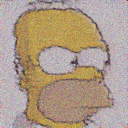

In [69]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, 500)

  0%|          | 0/200 [00:00<?, ?it/s]

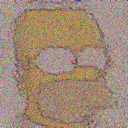

In [70]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, 200)

  0%|          | 0/100 [00:00<?, ?it/s]

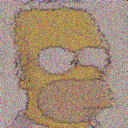

In [71]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, 100)

  0%|          | 0/50 [00:00<?, ?it/s]

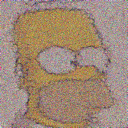

In [72]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, 50)

  0%|          | 0/1 [00:00<?, ?it/s]

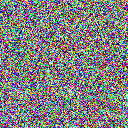

In [73]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, 1)